## Brain tumor classification using DenseNet Transfer Learning 



It could be interessant to perfom transfer learning and partial fine tuning when you have not enough data to train a model. You could use pretrained model with Fed-BioMed and fine-tune the last layers with your specific data.

Here is an example With a public dataset of MRI (Brain dataset from Kaggle). I tested different approaches to train or fine-tune train the DenseNet model to classify images in tumor or healthy brain images.





In [1]:

!pip install torch-summary


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
#from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
#import splitfolders
from torchsummary import summary
#import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [3]:
labels_df = pd.read_csv("/user/ebirgy/home/Downloads/Brain_Tumor_IRM/metadata.csv") # paths needs to be completed 
labels_df.drop(columns=['Unnamed: 0'], inplace=True)
print(labels_df.head().to_markdown())

|    | image           | class   | format   | mode   | shape         |
|---:|:----------------|:--------|:---------|:-------|:--------------|
|  0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


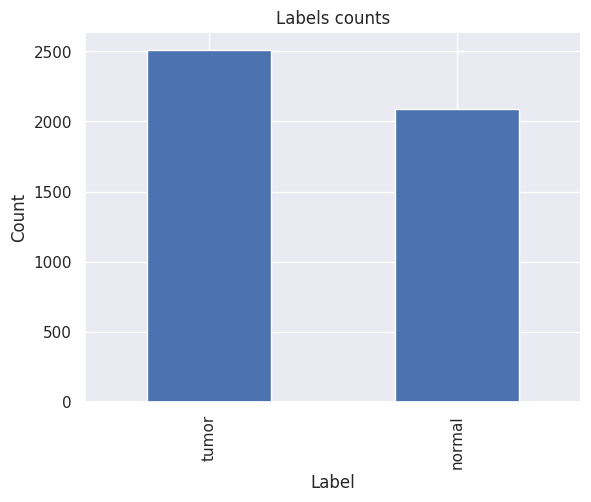

In [4]:
labels_df["class"].value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [5]:
# Encoding des categories : création d'un dictionnaire
label={'tumor': "1", 'normal': "0"}

In [6]:
dict_label=dict(label)
labels_df["label"]=labels_df['class'].map(dict_label)

In [7]:
# Specify the path where the images are located
path = "/user/ebirgy/home/Downloads/Brain_Tumor_IRM/"
# Add a new column 'full_path' to the DataFrame
labels_df['path_images'] = path + labels_df['image']


In [8]:
labels_df.head()

,image,class,format,mode,shape,label,path_images
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
1,Cancer (1).png,tumor,PNG,L,"(300, 240)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)",1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...


In [9]:
dataset=labels_df[['path_images', 'label', 'image']]
dataset['label']=dataset['label'].astype('int')

In [10]:
dataset.head()

,path_images,label,image
0,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (1).jpg
1,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (1).png
2,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (1).tif
3,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (10).jpg
4,/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Ca...,1,Cancer (10).tif


In [11]:
dataset.to_csv("../cancer_labels.csv")
df = pd.read_csv("../cancer_labels.csv", index_col=0)

In [12]:
df.iloc[0, 0]

'/user/ebirgy/home/Downloads/Brain_Tumor_IRM/Cancer (1).jpg'

In [15]:
from fedbiomed.researcher.requests import Requests
req  = Requests()
req.list()

2024-01-19 13:15:47,611 fedbiomed INFO - Starting researcher service...
2024-01-19 13:15:47,612 fedbiomed INFO - Waiting 3s for nodes to connect...
2024-01-19 13:15:49,547 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:15:49,548 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:15:50,624 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks


{'NODE_7842724a-cafa-49cc-862d-149288bbbb22': [{'name': 'Cancer image labels',
   'data_type': 'csv',
   'tags': ['cancer'],
   'description': 'This dataset keeps the img path for all classes of cancer images',
   'shape': [4600, 4],
   'dataset_id': 'dataset_eefc95a8-dd37-476c-90d0-0ee33bcee8c9',
   'dataset_parameters': None}]}

In [ ]:
from fedbiomed.common.training_plans import TorchTrainingPlan 
from fedbiomed.common.data import DataManager
from torch.utils.data import Dataset
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

## Change only classification's layer

In [46]:
class MyTrainingPlan2(TorchTrainingPlan):

    def init_model(self, model_args):
        # Define your custom classification layer
        class CustomClassifier(nn.Module):
            def __init__(self, in_features, num_classes):
                super(CustomClassifier, self).__init__()
                self.fc = nn.Linear(in_features, num_classes)
        
            def forward(self, x):
                x = self.fc(x)
                return x
        
        # Load the pre-trained DenseNet model
        model = models.densenet121(pretrained=True)
        
        # Modify the classifier layer
        in_features = model.classifier.in_features
        num_classes = model_args['num_classes']  # Change this to the number of classes in your dataset
        custom_classifier = CustomClassifier(in_features, num_classes)
        
        # Replace the classifier
        model.classifier = custom_classifier
        
        return model

    def init_dependencies(self):
        return [
            "import pandas as pd",
            "from PIL import Image",
            "from torchvision import datasets, transforms, models",
            "from torch.utils.data import Dataset",
            "import torch.optim as optim"
        ]


    def init_optimizer(self, optimizer_args):        
        return optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])

    # training data
    class CustomDatasetFedBioMed(Dataset):
        def __init__(self, dataset_path: str, transform=None):
            self.dataframe = pd.read_csv(dataset_path, index_col=0)
            
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
           ])
    
        def __len__(self):
            return len(self.dataframe)
    
        def __getitem__(self, idx):
            
            img_path = self.dataframe.iloc[idx, 0]  # the file path is in the first column
            print(img_path)
            image = Image.open(img_path).convert("RGB")
    
            label = self.dataframe.iloc[idx, 1]  # the class label is in the second column
    
            if self.transform:
                image = self.transform(image)
    
            label = torch.tensor(label, dtype=torch.long)  # if it returns a tuple instead of a tensor
    
            return image, label 

    def training_data(self):
        dataset = self.CustomDatasetFedBioMed(self.dataset_path)
        return DataManager(dataset)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss_func = nn.CrossEntropyLoss()
        loss   = loss_func(output, target)
        return loss



In [47]:
training_args = {
    'loader_args': { 'batch_size': 32, }, 
    'optimizer_args': {'lr': 1e-4}, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

model_args = {
    'num_classes': 2
}

In [48]:

tags =  ['cancer']
rounds = 1

exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan2,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage())

from fedbiomed.common.metrics import MetricTypes
exp.set_test_ratio(.1)
exp.set_test_on_local_updates(True)
exp.set_test_metric(MetricTypes.ACCURACY)

exp.set_tensorboard(True)

2024-01-19 14:04:30,134 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:04:30,135 fedbiomed INFO - Node selected for training -> NODE_7842724a-cafa-49cc-862d-149288bbbb22
2024-01-19 14:04:30,138 fedbiomed DEBUG - Model file has been saved: /home/ebirgy/development/fedbiomed_github/fedbiomed/var/experiments/Experiment_0018/model_ca06f829-6654-420b-ab9a-4e8cc6c8e0f8.py
2024-01-19 14:04:30,293 fedbiomed DEBUG - using native torch optimizer
2024-01-19 14:04:30,294 fedbiomed INFO - Removing tensorboard logs from previous experiment
2024-01-19 14:04:30,297 fedbiomed DEBUG - Experimentation training_args updated for `job`
2024-01-19 14:04:30,297 fedbiomed DEBUG - Experimentation training_args updated for `job`
2024-01-19 14:04:30,298 fedbiomed DEBUG - Experimentation training_args updated for `job`


True

In [49]:
exp.run()

2024-01-19 14:04:32,514 fedbiomed INFO - Sampled nodes in round 0 ['NODE_7842724a-cafa-49cc-862d-149288bbbb22']
2024-01-19 14:04:32,522 fedbiomed INFO - Sending request 
					 To: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Request: : TRAIN
 -----------------------------------------------------------------
2024-01-19 14:04:32,698 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:04:37,229 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 1/100 (1%) | Samples: 32/3200
 					 Loss: 0.734522 
					 ---------
2024-01-19 14:04:44,797 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:05:17,964 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 10/100 (10%) | Samples: 320/3200
 					 Loss: 0.364830 
					 ---------
2024-01-19 14:05:27,880 fedbiome

1

2024-01-19 14:12:33,838 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:12:33,842 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:12:44,661 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:13:33,831 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:13:44,657 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:13:46,415 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:13:58,430 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:14:46,416 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:14:58,425 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for th

In [27]:
exp.training_plan().export_model('./training_plan2_densenet')

2024-01-19 13:35:02,686 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:35:17,355 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:35:45,990 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:35:58,255 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:36:17,357 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:36:22,889 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:36:58,251 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:37:02,754 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:37:22,888 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for th

## Fine-tune : train last layers 

In [32]:
class MyTrainingPlan3(TorchTrainingPlan):

    def init_model(self, model_args):
        model = models.densenet121(pretrained=True)
        # For example, let's freeze all layers up to the second-to-last dense block
        for param in model.features[:-6].parameters():
            param.requires_grad = False

        # Modify the classifier to match the number of classes in your dataset
        num_ftrs = model.classifier.in_features
        num_classes = model_args['num_classes'] 
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
            )
        
        return model

    def init_dependencies(self):
        return [
            "import pandas as pd",
            "from PIL import Image",
            "from torchvision import datasets, transforms, models",
            "from torch.utils.data import Dataset",
            "import torch.optim as optim"
        ]


    def init_optimizer(self, optimizer_args):        
        return optim.Adam(self.model().parameters(), lr=optimizer_args["lr"])

    # training data
    class CustomDatasetFedBioMed(Dataset):
        def __init__(self, dataset_path: str, transform=None):
            self.dataframe = pd.read_csv(dataset_path, index_col=0)
            
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),  
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
           ])
    
        def __len__(self):
            return len(self.dataframe)
    
        def __getitem__(self, idx):
            
            img_path = self.dataframe.iloc[idx, 0]  # the file path is in the first column
            print(img_path)
            image = Image.open(img_path).convert("RGB")
    
            label = self.dataframe.iloc[idx, 1]  # the class label is in the second column
    
            if self.transform:
                image = self.transform(image)
    
            label = torch.tensor(label, dtype=torch.long)  # if it returns a tuple instead of a tensor
    
            return image, label 

    def training_data(self):
        dataset = self.CustomDatasetFedBioMed(self.dataset_path)
        return DataManager(dataset)

    def training_step(self, data, target):
        output = self.model().forward(data)
        loss_func = nn.CrossEntropyLoss()
        loss   = loss_func(output, target)
        return loss




In [40]:
training_args = {
    'loader_args': { 'batch_size': 32, }, 
    'optimizer_args': {'lr': 1e-4}, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

model_args = {
    'num_classes': 2
}

In [41]:
tags =  ['cancer']
rounds = 1


exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan3,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage())


from fedbiomed.common.metrics import MetricTypes
exp.set_test_ratio(.1)
exp.set_test_on_local_updates(True)
exp.set_test_metric(MetricTypes.ACCURACY)

exp.set_tensorboard(True)

2024-01-19 13:55:09,109 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:55:09,110 fedbiomed INFO - Node selected for training -> NODE_7842724a-cafa-49cc-862d-149288bbbb22
2024-01-19 13:55:09,112 fedbiomed DEBUG - Model file has been saved: /home/ebirgy/development/fedbiomed_github/fedbiomed/var/experiments/Experiment_0017/model_991dbbf4-9893-4022-8b9e-e479733dfd50.py
2024-01-19 13:55:09,279 fedbiomed DEBUG - using native torch optimizer
2024-01-19 13:55:09,280 fedbiomed DEBUG - Experimentation training_args updated for `job`
2024-01-19 13:55:09,280 fedbiomed DEBUG - Experimentation training_args updated for `job`
2024-01-19 13:55:09,281 fedbiomed DEBUG - Experimentation training_args updated for `job`


True

In [42]:
from fedbiomed.researcher.environ import environ
tensorboard_dir = environ['TENSORBOARD_RESULTS_DIR']

In [43]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [44]:
%tensorboard --logdir "$tensorboard_dir"

Reusing TensorBoard on port 6006 (pid 125337), started 0:01:23 ago. (Use '!kill 125337' to kill it.)

In [45]:
exp.run()

2024-01-19 13:55:16,732 fedbiomed INFO - Sampled nodes in round 0 ['NODE_7842724a-cafa-49cc-862d-149288bbbb22']
2024-01-19 13:55:16,747 fedbiomed INFO - Sending request 
					 To: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Request: : TRAIN
 -----------------------------------------------------------------
2024-01-19 13:55:16,899 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:55:19,800 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 1/100 (1%) | Samples: 32/3200
 					 Loss: 0.707718 
					 ---------
2024-01-19 13:55:42,409 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 13:55:44,434 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_7842724a-cafa-49cc-862d-149288bbbb22 
					 Round 1 Epoch: 1 | Iteration: 10/100 (10%) | Samples: 320/3200
 					 Loss: 0.502873 
					 ---------
2024-01-19 13:56:12,935 fedbiome

1

2024-01-19 14:00:44,951 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:00:53,142 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:01:04,387 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:01:16,844 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:01:53,136 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:02:07,916 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:02:16,843 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:02:22,008 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for the tasks
2024-01-19 14:03:07,912 fedbiomed DEBUG - Node: NODE_7842724a-cafa-49cc-862d-149288bbbb22 polling for th